In [1]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch
import json
import nltk
from tqdm import tqdm
from pathlib import Path
tqdm.pandas()
# nltk.download('stopwords')
# nltk.download('punkt')
%matplotlib inline
IMAGE_PATH = Path("/etlstage/PEE_joint/mine/image_data")


In [2]:
nltk.data.path.append("/home/hdfsf10n/nltk_data")
nltk.data.path

['/home/hdfsf10n/nltk_data',
 '/anaconda_env/projects/mark_ii/gpu_py37/nltk_data',
 '/anaconda_env/projects/mark_ii/gpu_py37/share/nltk_data',
 '/anaconda_env/projects/mark_ii/gpu_py37/lib/nltk_data',
 '/usr/share/nltk_data',
 '/usr/local/share/nltk_data',
 '/usr/lib/nltk_data',
 '/usr/local/lib/nltk_data',
 '/home/hdfsf10n/nltk_data']

In [3]:
%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader

In [4]:
with open('./data/vaild_dataset.json', 'r') as outfile:
  product_info = pd.read_json(json.load(outfile), orient="records")
  
product_info["file_loc"] = product_info["file_name"].apply(lambda file_name : IMAGE_PATH/file_name)
product_info

product_info.head()

title  \
0  14k Yellow Gold 3mm Half Round Plain Wedding Band   
1         14k Gold 4mm Half Round Plain Wedding Band   
2  18k Yellow Gold 7mm Comfort Fit Milgrain Plain...   
3    Sterling Silver Gold Plated Blue Topaz Earrings   
4                    Kenneth Cole_Watch Watch KC3489   

                                     imageURLHighRes  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                         description     perCategory  valid  \
0  [With its smooth surface and high polish, this...  AMAZON_FASHION   True   
1  [With its smooth surface and high polish, this...  AMAZON_FASHION   True   
2  [With its smooth surface and high polish, this...  AMAZON_FASHION   True   
3  [Gemstone Specifications: Number of Stones - 2...  AMAZON_FASHION   True   
4  [Dynamic Kenneth Cole style... modern, contemp...  AMAZON_FASHION   True   

         file_name                                           file_loc  
0  41WGCY65ENL.jpg  /etlstage/PEE_joint/mine/image_data/41WGCY65EN...  
1  31ZCFMXJ8SL.jpg  /etlstage/PEE_joint/mine/image_data/31ZCFMXJ8S...  
2  41QEG6NF5NL.jpg  /etlstage/PEE_joint/mine/image_data/41QEG6NF5N...  
3  31XXGCSPD5L.jpg  /etlstage/PEE_joint/mine/image_data/31XXGCSPD5...  
4  41kp1s7tN2L.jpg  /etlstage/PEE_joint/mine/image_data/41kp1s7tN2...

In [5]:
product_info["perCategory"].unique()

array(['AMAZON_FASHION', 'All_Beauty', 'Arts_Crafts_and_Sewing'],
      dtype=object)

14k Yellow and White Gold Engraved Plain Wedding Band
AMAZON_FASHION
/etlstage/PEE_joint/mine/image_data/41935SJ3HKL.jpg


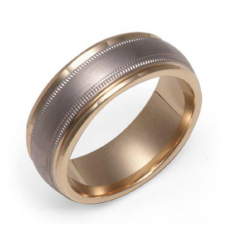

In [6]:
idex = 10
# img_url = product_info.loc[idex,"imageURLHighRes"]
img_loc = product_info.loc[idex,"file_loc"]
caption = product_info.loc[idex,"title"]
Category = product_info.loc[idex,"perCategory"]
print(caption)
print(Category)
print(img_loc)
I = io.imread(img_loc)
plt.axis('off')
plt.imshow(I)

In [7]:
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder

image_dict = product_info["file_loc"].to_dict()
caption_dict = product_info["title"].to_dict()
category_dict = product_info["perCategory"].to_dict()
onehot_cat = OneHotEncoder().fit_transform(np.array([*category_dict.values()], dtype=object).reshape(-1, 1)).toarray()

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

mode = "train"

# Specify the batch size.
# we will pass 10 images at a time. So, m = 10
batch_size = 10

In [8]:
%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_loader = get_loader(product_info,
                        transform=transform_train,
                        mode='train',
                        image_type="file_loc",
                        batch_size=batch_size,
                        vocab_threshold=vocab_threshold,
                        vocab_from_file=False)

print('The shape of first image:', data_loader.dataset[0][0].shape)
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, onehot_cat, captions = next(iter(data_loader))
    
print('images.shape:', images.shape)
print('onehot_cat.shape:', onehot_cat.shape)
print('captions.shape:', captions.shape)

100%|██████████| 692/692 [00:00<00:00, 10304.76it/s]

[0/692] Tokenizing captions...
Obtaining caption lengths...
The shape of first image: torch.Size([3, 320, 320])
Total number of tokens in vocabulary: 434
sampled indices: [470, 674, 199, 474, 43, 251, 137, 19, 483, 256]


images.shape: torch.Size([10, 3, 320, 320])
onehot_cat.shape: torch.Size([10, 1, 3])
captions.shape: torch.Size([10, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


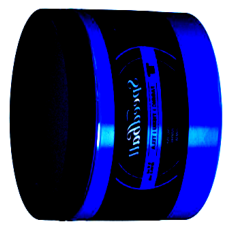

In [10]:
plt.axis('off')
plt.imshow(images[0].detach().T)
plt.show()

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import sys
import os
import math
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import nltk
from nltk.translate.bleu_score import corpus_bleu

%load_ext autoreload
%autoreload
from src.utils.data_loader import get_loader
from src.models.CNN_Encoder import EncoderCNN
from src.models.RNN_Decoder import DecoderRNN
from src.models.MLP_Encoder import MlpEncoder
from src.utils.utils_trainer import get_batch_caps, get_hypothesis, adjust_learning_rate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def train(epoch, 
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion, 
          total_step, 
          num_epochs, 
          data_loader, 
          write_file, 
          save_every = 1):
    """ Train function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder
    - decoder - model's Decoder
    - optimizer - model's optimizer (Adam in our case)
    - criterion - loss function to optimize
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the training logs
    
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    
    for i_step in range(1, total_step+1):
        # training mode on
        encoder.train() # no fine-tuning for Encoder
        # mlp.train()
        decoder.train()
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, onehot_cat, captions = next(iter(data_loader))
        # target captions, excluding the first word
        captions_target = captions[:, 1:].to(device) 
        # captions for training without the last word
        captions_train = captions[:, :-1].to(device)

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)

        # onehot_cat = onehot_cat.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        # mlp.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)

        outputs, atten_weights = decoder(captions= captions_train,
                                         features = features)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        perplex = np.exp(loss.item())
        epoch_loss += loss.item()
        epoch_perplex += perplex
        
        stats = 'Epoch train: [%d/%d], Step train: [%d/%d], Loss train: %.4f, Perplexity train: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
        
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    
    print('\r')
    print('Epoch train:', epoch)
    print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
    print('\r')
    
    # Save the weights.
    # if epoch % save_every == 0:
    #     torch.save(decoder.state_dict(), os.path.join('./models_new', 'decoder-%d.pkl' % epoch))
    #     torch.save(encoder.state_dict(), os.path.join('./models_new', 'encoder-%d.pkl' % epoch))

In [13]:
def validate(epoch, 
             encoder, 
             decoder, 
             encoder_optimizer, 
             decoder_optimizer, 
             criterion, 
             total_step, num_epochs, data_loader, write_file, bleu_score_file):
    """ Validation function for a single epoch. 
    Arguments: 
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder (evaluation)
    - decoder - model's Decoder (evaluation)
    - optimizer - model's optimizer (Adam in our case)
    - criterion - optimized loss function
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the validation logs
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0
    references = []
    hypothesis = []
      
    for i_step in range(1, total_step+1):
        # evaluation of encoder and decoder
        encoder.eval()
        decoder.eval()
        val_images, val_onehot_cat, val_captions, caps_all = next(iter(data_loader))
        
        val_captions_target = val_captions[:, 1:].to(device) 
        val_captions = val_captions[:, :-1].to(device)
        val_images = val_images.to(device)
    
        
        features_val = encoder(val_images)
        outputs_val, atten_weights_val = decoder(captions= val_captions,
                                         features = features_val)
        loss_val = criterion(outputs_val.view(-1, vocab_size), 
                             val_captions_target.reshape(-1))
        
        # preprocess captions and add them to the list
        caps_processed = get_batch_caps(caps_all, batch_size=batch_size)
        references.append(caps_processed)
        # get corresponding indicies from predictions
        # and form hypothesis from output
        terms_idx = torch.max(outputs_val, dim=2)[1]
        hyp_list = get_hypothesis(terms_idx, data_loader=data_loader)
        hypothesis.append(hyp_list)
        
        perplex = np.exp(loss_val.item())
        epoch_loss += loss_val.item()
        epoch_perplex += perplex
        
        stats = 'Epoch valid: [%d/%d], Step valid: [%d/%d], Loss valid: %.4f, Perplexity valid: %5.4f' % (epoch, num_epochs, i_step, total_step, loss_val.item(), perplex)
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        write_file.write(stats + '\n')
        write_file.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    
    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
            
    # prepare the proper shape for computing BLEU scores
    references = np.array(references).reshape(total_step*batch_size, -1)
    #hyps = np.array(hypothesis).reshape(total_step*batch_size, -1)
    hyps = np.concatenate(np.array(hypothesis))
        
    bleu_1 = corpus_bleu(references, hyps, weights = (1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hyps, weights = (0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hyps, weights = (1.0/3.0, 1.0/3.0, 1.0/3.0, 0))
    bleu_4 = corpus_bleu(references, hyps, weights = (0.25, 0.25, 0.25, 0.25))
    # append individual n_gram scores
    #bleu_score_list.append((bleu_1, bleu_2, bleu_3, bleu_4))
    
    print('\r')
    print('Epoch valid:', epoch)
    epoch_stat = 'Avg. Loss valid: %.4f, Avg. Perplexity valid: %5.4f, \
    BLEU-1: %.2f, BLEU-2: %.2f, BLEU-3: %.2f, BLEU-4: %.2f' % (epoch_loss_avg, epoch_perp_avg, bleu_1, bleu_2, bleu_3, bleu_4)
    
    print('\r' + epoch_stat, end="")
    print('\r')
    
    bleu_score_file.write(epoch_stat + '\n')
    bleu_score_file.flush()
    return bleu_1, bleu_2, bleu_3, bleu_4

In [14]:
batch_size = 10          # batch size, change to 64
vocab_threshold = 3        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 125           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_features = 2048        # number of feature maps, produced by Encoder
num_epochs = 200               # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

log_train = './logs/training_log.txt'       # name of files with saved training loss and perplexity
log_val = './logs/validation_log.txt'
bleu = './logs/bleu.txt'

In [15]:
train_df, test_df = train_test_split(product_info, test_size=0.2)
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)


transform_train = transforms.Compose([ 
    transforms.Resize(500),                          # smaller edge of image resized to 256
    transforms.Resize((320,320)),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(train_df,
                         transform=transform_train,
                         mode='train',
                         image_type="file_loc",
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Setup the transforms
transform_test = transforms.Compose([ 
    transforms.Resize((320,320)),                   # smaller edge of image resized to 500
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.

valid_data_loader = get_loader(test_df,
                               transform=transform_train,
                               mode='valid',
                               image_type="file_loc",
                               batch_size=batch_size)


total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
total_step_valid

100%|██████████| 139/139 [00:00<00:00, 10295.04it/s]

[0/553] Tokenizing captions...
Obtaining caption lengths...
Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


14

In [16]:
# Initialize the encoder and decoder. 
encoder = EncoderCNN()
decoder = DecoderRNN(num_features = num_features, 
                     embedding_dim = embed_size, 
                     hidden_dim = hidden_size, 
                     vocab_size = vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embeddings): Embedding(560, 125)
  (lstm): LSTMCell(2173, 512)
  (fc): Linear(in_features=512, out_features=560, bias=True)
  (attention): TranslateAttention(
    (W_a): Linear(in_features=2048, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

In [17]:
print(device)
# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

#params = list(decoder.parameters()) + list(encoder.parameters()) 
params = list(decoder.parameters())

# TODO #4: Define the optimizer.
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper

encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),lr=encoder_lr)

decoder_lr = 1.2e-4  # learning rate for decoder
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=decoder_lr)

fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

cuda


In [18]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M-%S")
if not os.path.exists(f'/etlstage/PEE_joint/mine/models_new/{current_time}'):
  os.makedirs(f'/etlstage/PEE_joint/mine/models_new/{current_time}')

# Open the training log file.
file_train = open(log_train, 'w')
file_val = open(log_val, 'w')
bleu_score_file = open(bleu, 'w')

# store BLEU scores in list 
bleu_scores = []
total_step_valid = math.ceil(len(valid_data_loader.dataset.caption_lengths) / valid_data_loader.batch_sampler.batch_size)
epochs_since_improvement = 0
best_bleu = 0.

for epoch in range(0, num_epochs+1):
    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 30:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 20 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    train(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, total_step, num_epochs =num_epochs,
          data_loader = data_loader,
          write_file = file_train, 
          save_every = 1)
    
    bleus= validate(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
                                             total_step = total_step_valid, 
                                             num_epochs = num_epochs, 
                                             data_loader = valid_data_loader, write_file=file_val, bleu_score_file=bleu_score_file)
    # Check if there was an improvement
    is_best = sum(bleus)/4 > best_bleu
    best_bleu = max(sum(bleus)/4, best_bleu)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        torch.save(decoder.state_dict(), os.path.join(f'/etlstage/PEE_joint/mine/models_new/{current_time}', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join(f'/etlstage/PEE_joint/mine/models_new/{current_time}', 'encoder-%d.pkl' % epoch))
        epochs_since_improvement = 0
    
file_train.close()
file_val.close()
bleu_score_file.close()

Epoch train: [0/200], Step train: [56/56], Loss train: 5.0301, Perplexity train: 152.9495
Epoch train: 0
Avg. Loss train: 5.2920, Avg. Perplexity train: 236.0638
Epoch valid: [0/200], Step valid: [14/14], Loss valid: 3.8108, Perplexity valid: 45.1860

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 0
Avg. Loss valid: 3.8049, Avg. Perplexity valid: 44.9210,     BLEU-1: 0.00, BLEU-2: 0.00, BLEU-3: 0.00, BLEU-4: 0.00

Epochs since last improvement: 1

Epoch train: [1/200], Step train: [56/56], Loss train: 4.9792, Perplexity train: 145.3593
Epoch train: 1
Avg. Loss train: 4.9400, Avg. Perplexity train: 171.9924
Epoch valid: [1/200], Step valid: [14/14], Loss valid: 3.8469, Perplexity valid: 46.8469

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 1
Avg. Loss valid: 3.8438, Avg. Perplexity valid: 46.7020,     BLEU-1: 0.02, BLEU-2: 0.00, BLEU-3: 0.00, BLEU-4: 0.00
Epoch train: [2/200], Step train: [56/56], Loss train: 3.9934, Perplexity train: 54.23752
Epoch train: 2
Avg. Loss train: 4.5381, Avg. Perplexity train: 127.2288
Epoch valid: [2/200], Step valid: [14/14], Loss valid: 3.9175, Perplexity valid: 50.2746

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 2
Avg. Loss valid: 3.9134, Avg. Perplexity valid: 50.0698,     BLEU-1: 0.15, BLEU-2: 0.09, BLEU-3: 0.07, BLEU-4: 0.00
Epoch train: [3/200], Step train: [56/56], Loss train: 4.3745, Perplexity train: 79.40163
Epoch train: 3
Avg. Loss train: 4.3138, Avg. Perplexity train: 100.1191
Epoch valid: [3/200], Step valid: [14/14], Loss valid: 3.7021, Perplexity valid: 40.5338

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 3
Avg. Loss valid: 3.7046, Avg. Perplexity valid: 40.6332,     BLEU-1: 0.15, BLEU-2: 0.09, BLEU-3: 0.07, BLEU-4: 0.00

Epochs since last improvement: 1

Epoch train: [4/200], Step train: [56/56], Loss train: 3.6843, Perplexity train: 39.81587
Epoch train: 4
Avg. Loss train: 4.2921, Avg. Perplexity train: 94.9614
Epoch valid: [4/200], Step valid: [14/14], Loss valid: 3.4382, Perplexity valid: 31.1312

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 4
Avg. Loss valid: 3.4453, Avg. Perplexity valid: 31.3521,     BLEU-1: 0.17, BLEU-2: 0.14, BLEU-3: 0.13, BLEU-4: 0.12
Epoch train: [5/200], Step train: [56/56], Loss train: 4.6718, Perplexity train: 106.8860
Epoch train: 5
Avg. Loss train: 3.8297, Avg. Perplexity train: 72.8614
Epoch valid: [5/200], Step valid: [14/14], Loss valid: 3.4833, Perplexity valid: 32.5655

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 5
Avg. Loss valid: 3.4808, Avg. Perplexity valid: 32.4872,     BLEU-1: 0.18, BLEU-2: 0.14, BLEU-3: 0.12, BLEU-4: 0.11

Epochs since last improvement: 1

Epoch train: [6/200], Step train: [56/56], Loss train: 3.1314, Perplexity train: 22.90626
Epoch train: 6
Avg. Loss train: 3.9373, Avg. Perplexity train: 77.7908
Epoch valid: [6/200], Step valid: [14/14], Loss valid: 3.2545, Perplexity valid: 25.9063

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 6
Avg. Loss valid: 3.2588, Avg. Perplexity valid: 26.0201,     BLEU-1: 0.16, BLEU-2: 0.15, BLEU-3: 0.14, BLEU-4: 0.13
Epoch train: [7/200], Step train: [56/56], Loss train: 4.6569, Perplexity train: 105.3116
Epoch train: 7
Avg. Loss train: 3.6804, Avg. Perplexity train: 62.6311
Epoch valid: [7/200], Step valid: [14/14], Loss valid: 3.7589, Perplexity valid: 42.8999

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 7
Avg. Loss valid: 3.7690, Avg. Perplexity valid: 43.3384,     BLEU-1: 0.09, BLEU-2: 0.08, BLEU-3: 0.06, BLEU-4: 0.00

Epochs since last improvement: 1

Epoch train: [8/200], Step train: [56/56], Loss train: 4.3106, Perplexity train: 74.48290
Epoch train: 8
Avg. Loss train: 3.2463, Avg. Perplexity train: 39.0364
Epoch valid: [8/200], Step valid: [14/14], Loss valid: 3.7458, Perplexity valid: 42.3439

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 8
Avg. Loss valid: 3.7275, Avg. Perplexity valid: 41.5786,     BLEU-1: 0.21, BLEU-2: 0.17, BLEU-3: 0.15, BLEU-4: 0.12
Epoch train: [9/200], Step train: [56/56], Loss train: 2.0185, Perplexity train: 7.526903
Epoch train: 9
Avg. Loss train: 3.2963, Avg. Perplexity train: 45.1214
Epoch valid: [9/200], Step valid: [14/14], Loss valid: 3.7612, Perplexity valid: 42.9987

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 9
Avg. Loss valid: 3.7553, Avg. Perplexity valid: 42.7493,     BLEU-1: 0.27, BLEU-2: 0.17, BLEU-3: 0.10, BLEU-4: 0.00

Epochs since last improvement: 1

Epoch train: [10/200], Step train: [56/56], Loss train: 3.6765, Perplexity train: 39.50883
Epoch train: 10
Avg. Loss train: 3.4789, Avg. Perplexity train: 66.5060
Epoch valid: [10/200], Step valid: [14/14], Loss valid: 3.4443, Perplexity valid: 31.3211

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 10
Avg. Loss valid: 3.4364, Avg. Perplexity valid: 31.0766,     BLEU-1: 0.25, BLEU-2: 0.20, BLEU-3: 0.14, BLEU-4: 0.00

Epochs since last improvement: 2

Epoch train: [11/200], Step train: [56/56], Loss train: 2.2337, Perplexity train: 9.334564
Epoch train: 11
Avg. Loss train: 3.0573, Avg. Perplexity train: 39.4218
Epoch valid: [11/200], Step valid: [14/14], Loss valid: 3.3291, Perplexity valid: 27.9124

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 11
Avg. Loss valid: 3.3324, Avg. Perplexity valid: 28.0063,     BLEU-1: 0.34, BLEU-2: 0.22, BLEU-3: 0.17, BLEU-4: 0.13
Epoch train: [12/200], Step train: [56/56], Loss train: 5.3807, Perplexity train: 217.1701
Epoch train: 12
Avg. Loss train: 2.8096, Avg. Perplexity train: 28.5707
Epoch valid: [12/200], Step valid: [14/14], Loss valid: 3.1992, Perplexity valid: 24.5133

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 12
Avg. Loss valid: 3.1920, Avg. Perplexity valid: 24.3382,     BLEU-1: 0.21, BLEU-2: 0.16, BLEU-3: 0.12, BLEU-4: 0.09

Epochs since last improvement: 1

Epoch train: [13/200], Step train: [56/56], Loss train: 3.3905, Perplexity train: 29.68060
Epoch train: 13
Avg. Loss train: 2.8222, Avg. Perplexity train: 37.9158
Epoch valid: [13/200], Step valid: [14/14], Loss valid: 3.2301, Perplexity valid: 25.2822

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 13
Avg. Loss valid: 3.2339, Avg. Perplexity valid: 25.3793,     BLEU-1: 0.22, BLEU-2: 0.20, BLEU-3: 0.17, BLEU-4: 0.15

Epochs since last improvement: 2

Epoch train: [14/200], Step train: [56/56], Loss train: 2.9732, Perplexity train: 19.5551
Epoch train: 14
Avg. Loss train: 2.3696, Avg. Perplexity train: 14.3576
Epoch valid: [14/200], Step valid: [14/14], Loss valid: 3.2625, Perplexity valid: 26.1145

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 14
Avg. Loss valid: 3.2763, Avg. Perplexity valid: 26.4779,     BLEU-1: 0.21, BLEU-2: 0.17, BLEU-3: 0.13, BLEU-4: 0.10

Epochs since last improvement: 3

Epoch train: [15/200], Step train: [56/56], Loss train: 1.3779, Perplexity train: 3.966498
Epoch train: 15
Avg. Loss train: 2.4419, Avg. Perplexity train: 23.2237
Epoch valid: [15/200], Step valid: [14/14], Loss valid: 3.7338, Perplexity valid: 41.8374

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 15
Avg. Loss valid: 3.7217, Avg. Perplexity valid: 41.3361,     BLEU-1: 0.31, BLEU-2: 0.14, BLEU-3: 0.00, BLEU-4: 0.00

Epochs since last improvement: 4

Epoch train: [16/200], Step train: [56/56], Loss train: 2.5228, Perplexity train: 12.46321
Epoch train: 16
Avg. Loss train: 2.5800, Avg. Perplexity train: 21.6013
Epoch valid: [16/200], Step valid: [14/14], Loss valid: 3.6872, Perplexity valid: 39.9348

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 16
Avg. Loss valid: 3.7010, Avg. Perplexity valid: 40.4957,     BLEU-1: 0.34, BLEU-2: 0.31, BLEU-3: 0.27, BLEU-4: 0.21
Epoch train: [17/200], Step train: [56/56], Loss train: 0.8915, Perplexity train: 2.438745
Epoch train: 17
Avg. Loss train: 2.4466, Avg. Perplexity train: 21.0795
Epoch valid: [17/200], Step valid: [14/14], Loss valid: 3.8700, Perplexity valid: 47.9426

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Co


Epoch valid: 17
Avg. Loss valid: 3.8816, Avg. Perplexity valid: 48.5046,     BLEU-1: 0.26, BLEU-2: 0.14, BLEU-3: 0.09, BLEU-4: 0.00

Epochs since last improvement: 1

Epoch train: [18/200], Step train: [56/56], Loss train: 1.8199, Perplexity train: 6.171352
Epoch train: 18
Avg. Loss train: 2.5209, Avg. Perplexity train: 21.1901
Epoch valid: [18/200], Step valid: [14/14], Loss valid: 2.9869, Perplexity valid: 19.8234

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 18
Avg. Loss valid: 2.9755, Avg. Perplexity valid: 19.6002,     BLEU-1: 0.24, BLEU-2: 0.19, BLEU-3: 0.16, BLEU-4: 0.12

Epochs since last improvement: 2

Epoch train: [19/200], Step train: [56/56], Loss train: 1.7383, Perplexity train: 5.687415
Epoch train: 19
Avg. Loss train: 1.9908, Avg. Perplexity train: 13.0229
Epoch valid: [19/200], Step valid: [14/14], Loss valid: 3.0613, Perplexity valid: 21.3551

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 19
Avg. Loss valid: 3.0613, Avg. Perplexity valid: 21.3557,     BLEU-1: 0.24, BLEU-2: 0.17, BLEU-3: 0.13, BLEU-4: 0.08

Epochs since last improvement: 3

Epoch train: [20/200], Step train: [56/56], Loss train: 0.8962, Perplexity train: 2.45030
Epoch train: 20
Avg. Loss train: 2.1072, Avg. Perplexity train: 10.6870
Epoch valid: [20/200], Step valid: [14/14], Loss valid: 3.3600, Perplexity valid: 28.7889

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 20
Avg. Loss valid: 3.3826, Avg. Perplexity valid: 29.4504,     BLEU-1: 0.40, BLEU-2: 0.32, BLEU-3: 0.26, BLEU-4: 0.23
Epoch train: [21/200], Step train: [56/56], Loss train: 1.9631, Perplexity train: 7.12152
Epoch train: 21
Avg. Loss train: 2.1091, Avg. Perplexity train: 12.3840
Epoch valid: [21/200], Step valid: [14/14], Loss valid: 3.3291, Perplexity valid: 27.9119

/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/anaconda_env/projects/mark_ii/gpu_py37/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch valid: 21
Avg. Loss valid: 3.3478, Avg. Perplexity valid: 28.4438,     BLEU-1: 0.37, BLEU-2: 0.25, BLEU-3: 0.19, BLEU-4: 0.15

Epochs since last improvement: 1

Epoch train: [22/200], Step train: [52/56], Loss train: 3.5861, Perplexity train: 36.09485

KeyboardInterrupt: 